### Imports

In [1]:
import json
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from cycler import cycler
from pathlib import Path

import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from datasets import SurfaceDatasetXGB

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Color definitions
NICER_GREEN = '#159C48'
NICER_BLUE = '#00A0FF'
ORANGE = '#FBBC04'
PINK = '#DB00CF'
MAD_PURPLE = '#732BF5'
LIGHT_GREEN = '#66C2A5'

# Default figure parameters
DEFAULT_FIGURE_PARAMS = {
    'figure.figsize': [4, 3],
    'axes.prop_cycle': cycler('color',
                              [NICER_BLUE, NICER_GREEN, ORANGE, PINK, MAD_PURPLE, LIGHT_GREEN]),
    'lines.linewidth': 1.5,
    'font.size': 8,
}

# Statistical constants
T_95 = 2.228  # t-value for 95% confidence interval

def setup_matplotlib(custom_params=None):
    """Configure matplotlib with default or custom parameters.

    Parameters
    ----------
    custom_params : dict, optional
        Additional or override parameters.
    """
    params = DEFAULT_FIGURE_PARAMS.copy()
    if custom_params:
        params.update(custom_params)

    plt.rcParams.update(params)

In [3]:
DATA_DIR = Path('./Desktop/SC - revision/dataset_new/dataset') # TO DO
HISTORY_DIR = Path('./Desktop/SC - revision/results') # TO DO
LOOKBACK = 8/3
SAMPLING_FREQUENCY = 75.
DATASET_FREQUENCY = 150.
SUBSET = ('imu', 'servo')

In [5]:
def get_data(CONFIGURATIONS):
    with open('./Desktop/SC - revision/labels.json') as fp:
       labels = json.load(fp)

    dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in CONFIGURATIONS and values['spacing'] == 'R1' and 'T1' in values['trajectory']]
    
    X = pd.Series([run[0] for run in dataset], name='bag_name')
    y_primary = [run[1] for run in dataset]

    y_secondary = ['0' if label in ('3_Wykladzina_jasna', '4_Trawa')
                   else '2' if label in ('5_Spienione_PCV', '8_Pusta_plyta', '9_podklady', '10_Mata_ukladana')
                   else '1' for label in y_primary]
    
    lb = LabelEncoder()
    lb.fit(y_primary)
    classes = lb.classes_
    num_classes = len(classes)
    y = lb.transform(y_primary)
    
    original_labels = lb.inverse_transform(y)
    
    surface_map = {'1_Panele': 'Laminate flooring',
                '2_Wykladzina_czarna': 'Carpet (short fibers)',
                '3_Wykladzina_jasna': 'Carpet (long fibers)',
                '4_Trawa': 'Artificial grass',
                '5_Spienione_PCV': 'PVC foamboard',
                '6_Linoleum': 'Linoleum',
                '7_Plytki_w_sali': 'Ceramic tiles',
                '8_Pusta_plyta': 'OSB',
                '9_podklady': 'Foam underlayment',
                '10_Mata_ukladana': 'EVA foam tiles'}
    
    mapped_arr = np.vectorize(surface_map.get)(original_labels)
    
    cv_data = SurfaceDatasetXGB(X, y, sample_freq=SAMPLING_FREQUENCY, data_freq=DATASET_FREQUENCY, lookback=LOOKBACK, subset=SUBSET)

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 4, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0.1, 0.5],
        'reg_lambda': [0.1, 0.5],
        'scale_pos_weight': [1, 2, 3]
    }

    return Counter(y_secondary), Counter(mapped_arr)

In [6]:
def generate_hist(data1, data2):

    counts_6w = data1
    counts_4w = data2
    
    N = len(counts_6w.keys())
    ind = np.arange(N)
    
    fig, ax1 = plt.subplots()
    a1 = list(counts_4w.keys())
    b1 = list(counts_4w.values())
    
    a2 = list(counts_6w.keys())
    b2 = list(counts_6w.values())
    width = 0.3
    ax1.bar(ind, b1, width, color=NICER_BLUE, label='4W')
    ax1.bar(ind + width, b2, width, color=NICER_GREEN, label='6W')
    ax1.set_ylabel('number of runs')
    ax1.set_xlabel('surface type')
    ax1.set_title('')
    if N == 10: # add rotation
        plt.xticks(ind + width / 2, counts_4w.keys(), rotation=45, ha='right')
    else:
        plt.xticks(ind + width / 2, counts_4w.keys(), ha='right')
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(0.7, 1.2), ncol=2)
    plt.grid(axis='y')
    plt.savefig("hist_1000dpi.png", dpi=1000, bbox_inches='tight')
    # plt.show()

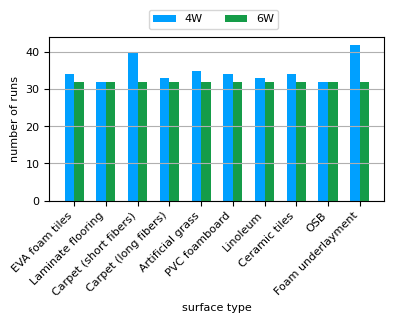

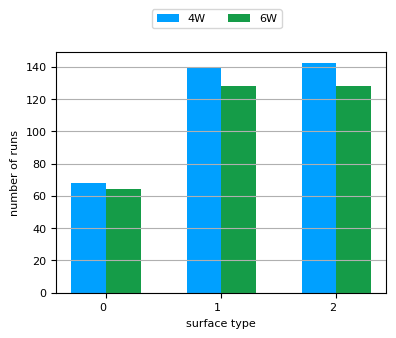

In [7]:
data_6w_3, data_6w_10 = get_data(CONFIGURATIONS='6W')
data_4w_3, data_4w_10 = get_data(CONFIGURATIONS='4W')

# sort labels for 3 classes
data_6w_3 = dict(sorted(data_6w_3.items(), key=lambda x: x[0]))
data_4w_3 = dict(sorted(data_4w_3.items(), key=lambda x: x[0]))

setup_matplotlib()
generate_hist(data_6w_10, data_4w_10)
generate_hist(data_6w_3, data_4w_3)